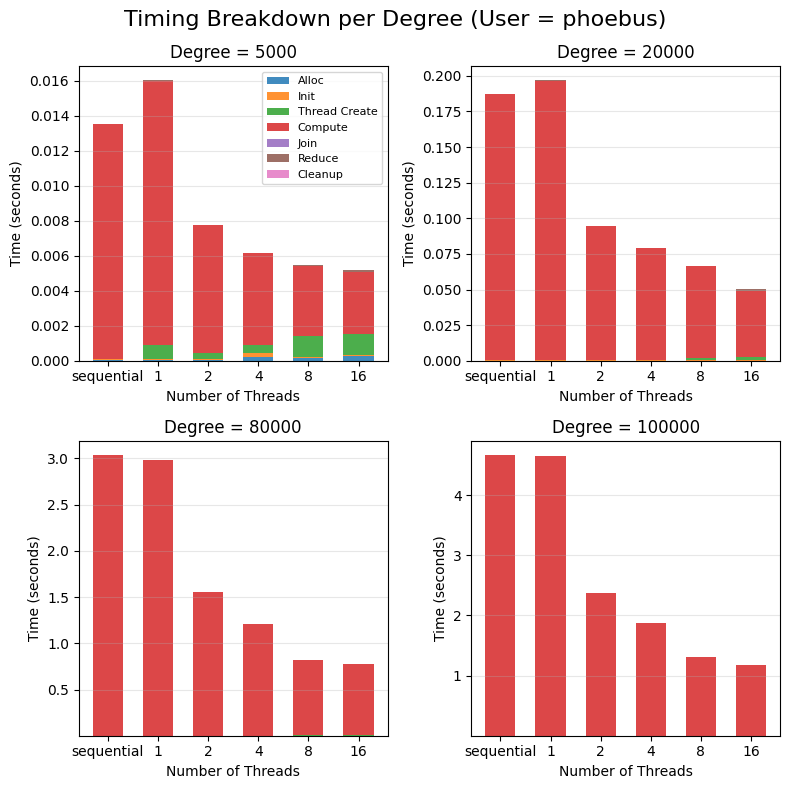

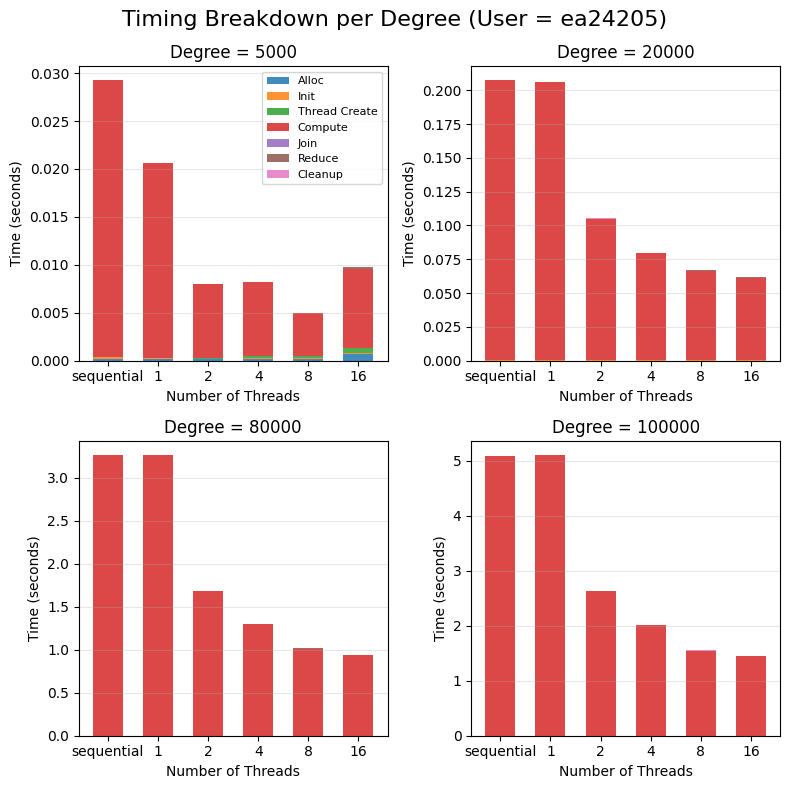

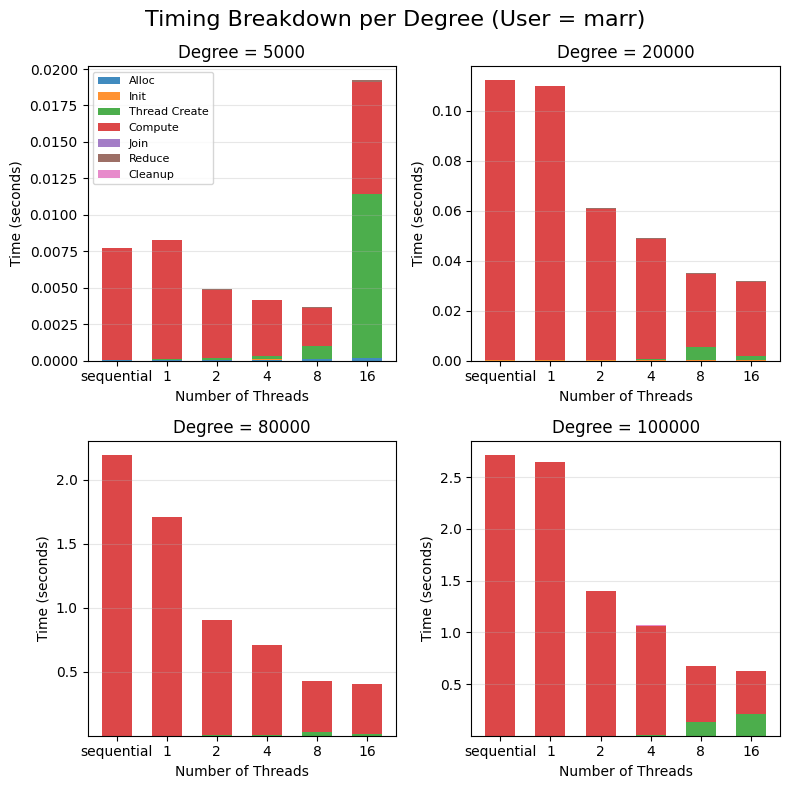

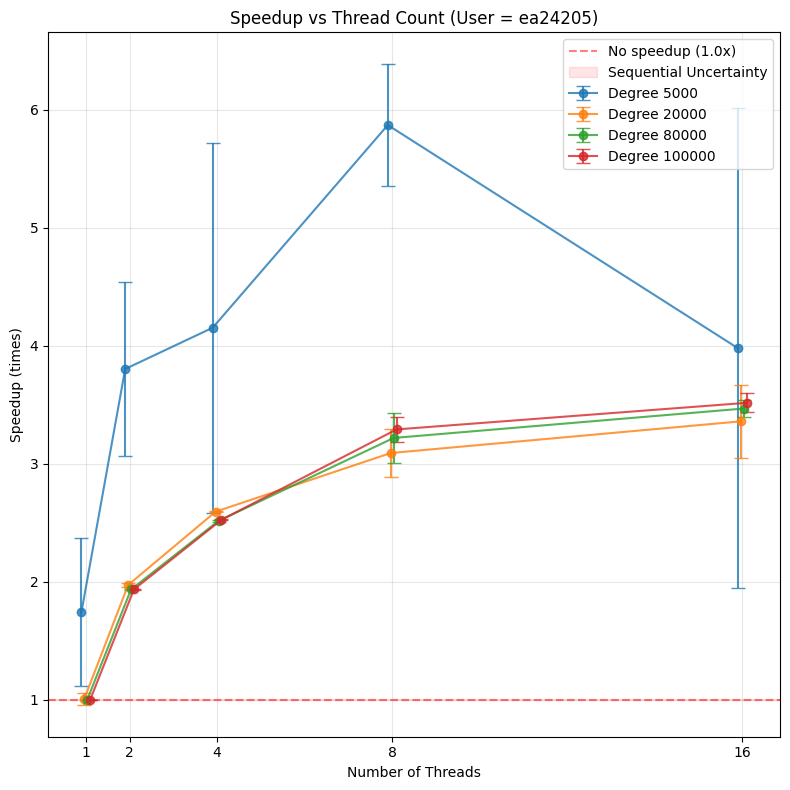

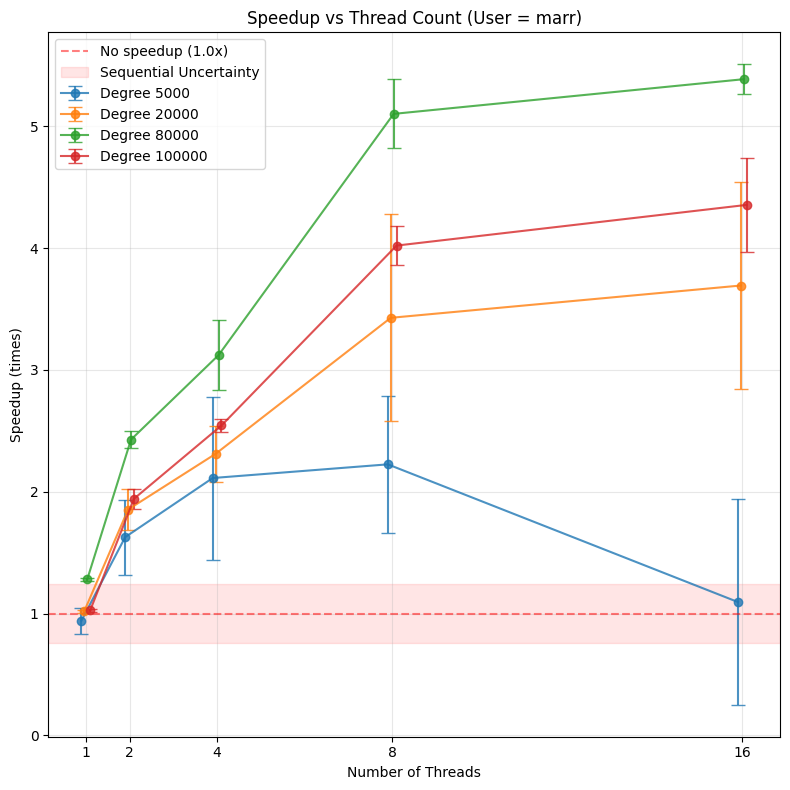

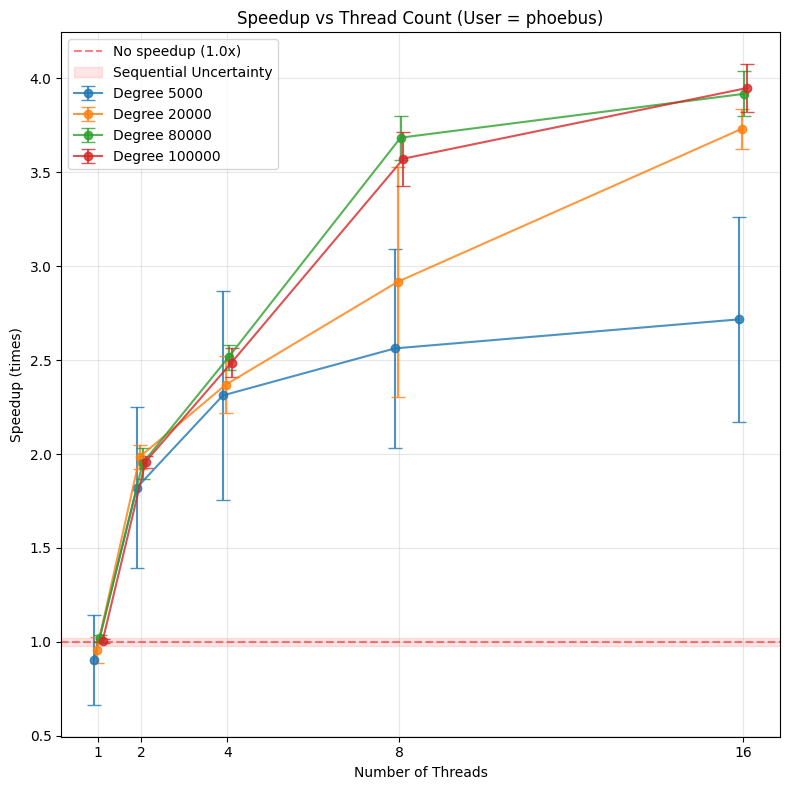

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

component_labels = {
    'time_alloc': 'Alloc', 'time_init': 'Init', 
    'time_cleanup': 'Cleanup'
}

res_df = pd.read_csv('results_4.1.csv')
os.makedirs('plots', exist_ok=True)

for selected_user in res_df['user'].unique():
    user_data = res_df[res_df['user'] == selected_user]
    degrees = sorted(user_data['degree'].unique())
    
    fig, axes = plt.subplots(2, 2, figsize=(10, 8))
    axes = axes.flatten()
    
    for idx, degree in enumerate(degrees):
        degree_data = user_data[user_data['degree'] == degree].mean(numeric_only=True)
        
        ax = axes[idx]
        x_labels = ['Sequential', 'SIMD']
        x_positions = np.arange(len(x_labels))
        
        seq_components = [degree_data['time_alloc'], degree_data['time_init'], degree_data['time_seq']]
        simd_components = [degree_data['time_alloc'], degree_data['time_init'], degree_data['time_simd']]
        
        seq_total = sum(seq_components) + degree_data['time_cleanup']
        simd_total = sum(simd_components) + degree_data['time_cleanup']
        
        width = 0.6
        ax.bar(0, degree_data['time_alloc'], width=width, label='Alloc', alpha=0.85, color='C0')
        ax.bar(1, degree_data['time_alloc'], width=width, alpha=0.85, color='C0')
        
        bottom_seq = degree_data['time_alloc']
        bottom_simd = degree_data['time_alloc']
        
        ax.bar(0, degree_data['time_init'], bottom=bottom_seq, width=width, label='Init', alpha=0.85, color='C1')
        ax.bar(1, degree_data['time_init'], bottom=bottom_simd, width=width, alpha=0.85, color='C1')
        
        bottom_seq += degree_data['time_init']
        bottom_simd += degree_data['time_init']
        
        ax.bar(0, degree_data['time_seq'], bottom=bottom_seq, width=width, label='Sequential', alpha=0.85, color='C2')
        ax.bar(1, degree_data['time_simd'], bottom=bottom_simd, width=width, label='SIMD', alpha=0.85, color='C3')
        
        bottom_seq += degree_data['time_seq']
        bottom_simd += degree_data['time_simd']
        
        ax.bar(0, degree_data['time_cleanup'], bottom=bottom_seq, width=width, label='Cleanup', alpha=0.85, color='C4')
        ax.bar(1, degree_data['time_cleanup'], bottom=bottom_simd, width=width, alpha=0.85, color='C4')
        
        speedup = degree_data['time_seq'] / degree_data['time_simd']
        ax.text(0.5, max(seq_total, simd_total) * 1.05, f'Speedup: {speedup:.2f}x', 
                ha='center', fontsize=10, fontweight='bold')
        
        ax.set_xlabel('Implementation')
        ax.set_ylabel('Time (seconds)')
        ax.set_title(f'Degree = {int(degree)}')
        ax.set_xticks(x_positions)
        ax.set_xticklabels(x_labels)
        if idx == 0:
            ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3, axis='y')
    
    fig.suptitle(f'Sequential vs SIMD Timing Breakdown (User = {selected_user})', fontsize=16)
    plt.tight_layout()
    plt.savefig(f'plots/timing_breakdown_seq_vs_simd_{selected_user}.png', dpi=300)
    plt.show()

for user in res_df['user'].unique():
    user_data = res_df[res_df['user'] == user]
    
    degrees = sorted(user_data['degree'].unique())
    speedups = []
    
    for degree in degrees:
        degree_data = user_data[user_data['degree'] == degree].mean(numeric_only=True)
        speedup = degree_data['time_seq'] / degree_data['time_simd']
        speedups.append(speedup)
    
    fig, ax = plt.subplots(figsize=(8, 8))
    
    x_positions = np.arange(len(degrees))
    bars = ax.bar(x_positions, speedups, alpha=0.8, color='steelblue', width=0.6)
    
    for i, (bar, speedup) in enumerate(zip(bars, speedups)):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{speedup:.2f}x', ha='center', va='bottom', fontsize=10, fontweight='bold')
    
    ax.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='No speedup (1.0x)')
    ax.axhline(y=8.0, color='g', linestyle='--', alpha=0.3, label='Theoretical max (8x for AVX2)')
    
    ax.set_xlabel('Polynomial Degree', fontsize=12)
    ax.set_ylabel('Speedup (times)', fontsize=12)
    ax.set_title(f'SIMD Speedup vs Sequential (User = {user})', fontsize=14)
    ax.set_xticks(x_positions)
    ax.set_xticklabels([f'{int(d)}' for d in degrees])
    ax.grid(True, alpha=0.3, axis='y')
    ax.legend()
    plt.tight_layout()
    plt.savefig(f'plots/speedup_simd_vs_seq_{user}.png', dpi=300)
    plt.show()
